The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x0 =  6.101404666900635


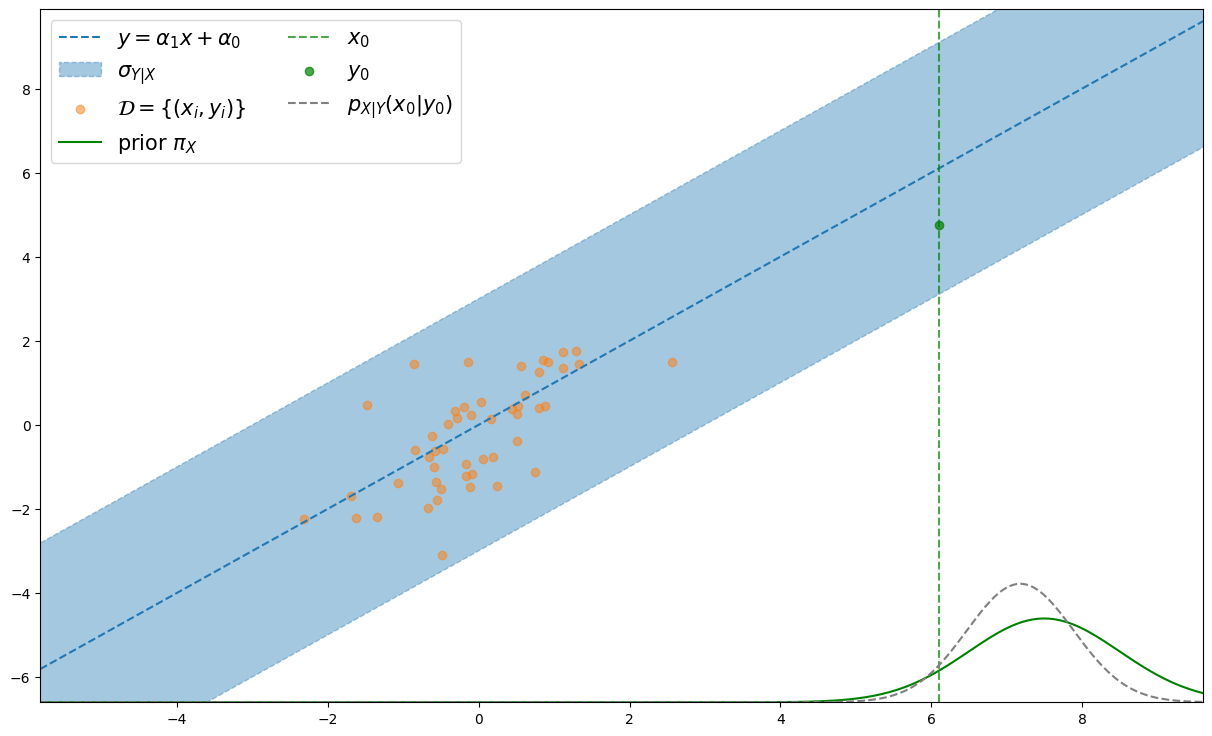

In [4]:
from misc import * 
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha = torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
alpha = torch.tensor([1.,0.])

mu_X =torch.tensor(7.5)
sigma2_X =torch.tensor(1.)
inference_prior = torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X))
x0 = inference_prior.sample()

prior_dataset = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1))
n_D = 50
DX =prior_dataset.sample([n_D])

sigma2_simulateur = torch.tensor(1)
f = lambda x: alpha[0]*x + alpha[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)

print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))

posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X, sigma2_X).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

y_min = torch.min(torch.cat([DY, torch.flatten(Y), y0]))-3.5
y_max = torch.max(torch.cat([DY, torch.flatten(Y), y0]))+3.5
x_min = torch.min(torch.cat([DX, torch.flatten(X), x0.unsqueeze(-1)]))-3.5
x_max = torch.max(torch.cat([DX, torch.flatten(X), x0.unsqueeze(-1)]))+3.5

plt.figure(figsize = (15,9))
ax = plt.subplot()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
plt.fill_between(tt.numpy(),f(tt).numpy() - 3*torch.sqrt(sigma20).numpy(),f(tt).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.4, label = r'$\sigma_{Y|X}$')
plt.scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_X$')
plt.axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
plt.scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')

plt.plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.ylim(y_min,)
plt.legend(ncol = 2, fontsize = 15)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x0 =  6.429629802703857


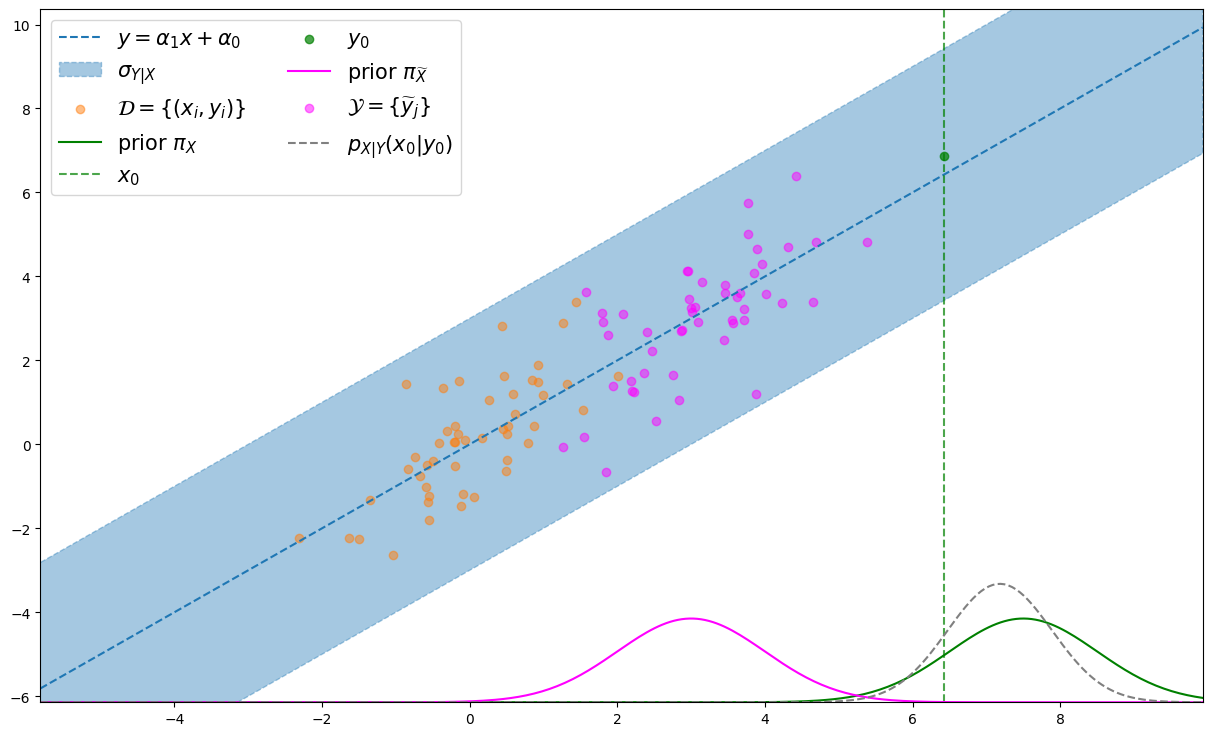

In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha = torch.tensor([1.,0.])

mu_X =torch.tensor(7.5)
sigma2_X =torch.tensor(1)
x0 =  torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).sample()

prior_dataset = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1))
n_D = 50
DX =prior_dataset.sample([n_D])

sigma2_simulateur = torch.tensor(1)
f = lambda x: alpha[0]*x + alpha[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)

print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))


posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X, sigma2_X).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

list_xj = []
list_yj = []
n_unlabeled_obs = 50
n_per_obs = 1
for t in torch.linspace(-10,10,n_unlabeled_obs):
    prior = torch.distributions.Normal(3, 1)
    xj = prior.sample()
    list_xj.append(xj.unsqueeze(0).repeat(n_per_obs))
    yj = simulateur(xj.unsqueeze(0).repeat(n_per_obs))
    list_yj.append(yj.unsqueeze(0))
if n_unlabeled_obs>0:
    Y = torch.cat(list_yj, dim = 0)
    X = torch.cat(list_xj, dim = 0)
else: 
    Y = torch.tensor([])
    X = torch.tensor([])
prior_means = 3*torch.ones(n_unlabeled_obs)
prior_sigma2s = torch.ones(n_unlabeled_obs)

y_min = torch.min(torch.cat([DY, y0]))-3.5
y_max = torch.max(torch.cat([DY, y0]))+3.5
x_min = torch.min(torch.cat([DX, x0.unsqueeze(-1)]))-3.5
x_max = torch.max(torch.cat([DX, x0.unsqueeze(-1)]))+3.5
tt = torch.linspace(x_min,x_max,300)


plt.figure(figsize = (15,9))
ax = plt.subplot()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
plt.fill_between(tt.numpy(),f(tt).numpy() - 3*torch.sqrt(sigma20).numpy(),f(tt).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.4, label = r'$\sigma_{Y|X}$')
plt.scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_X$')
plt.axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
plt.scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')

#hist = plt.hist(y0.numpy(), orientation ='horizontal', bins = n_y0, density = True,histtype = 'step', bottom = -3.5, label = r'histogramme de $y_0$')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(3, 1).log_prob(tt.unsqueeze(-1))), color = 'magenta', label=r'prior $\pi_{\widetilde{X}}$')
plt.scatter(X,Y,color = 'magenta', alpha = .5, label = r'$\mathcal{Y} = \{\widetilde{y}_j\}$')
plt.plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.ylim(y_min,)
plt.legend(ncol = 2, fontsize = 15)
plt.show()